In [1]:
from IPython.display import Image
from ipywidgets import interact, SelectionSlider
from lib.utils import *

## 2. Generative Adversarial Networks - 35 points

Please review Lecture 11 for the notation and the setup in this exercise, and the supplementary lecture on deep learning with PyTorch for the coding tricks.

After the LLM boom, Kocho realized his coding skills have become useless and he wants to make a career change. As Kocho cannot dance, he had to drop his dream of becoming a tiktok influencer. Kocho realized a lot of young people was creating clothing brands, and in his poor understanding of supply and demand, he thought this meant there was a high demand. But Kocho only knows how to code! How is he supposed to design clothes? Apparently there is this kind of AI called Wasserstein Generative Adversarial Networks (WGANs) that can do it for him. 

Your goal in this notebook is to fill in the gaps in Kocho's knowledge on how to get his WGAN to work. Specifically, both his generator neural network $h_\mathbf{x}$ (that outputs fake images) and dual variable neural network $d_\mathbf{y}$ (that scores images) are defined as convolutional neural networks in the following function classes:

\begin{equation}
\begin{aligned}
    \mathcal{H} & :=\{h: \mathbb{R}^{D} \to [0, 1]^{28 \times 28}| h_{\mathbf{x}}(\omega)=\sigma(c^T(\texttt{gelu}(c^T(\texttt{gelu}(c^T(\texttt{gelu}(c^T(\omega; X_1, \mu_1));X_2, \mu_2));X_3,\mu_3));X_4, \mu_4))\}, \\
    \qquad \mathcal{D} & := \{d: [0, 1]^{28 \times 28} \to \mathbb{R} | d_{\mathbf{y}}({\bf a})= Y_3 \cdot \texttt{leakyrelu}(c(\texttt{leakyrelu}(c({\bf a};Y_1,\nu_1));Y_2,\nu_2)) + \nu_3
    \},
\end{aligned}
\end{equation}

where $\mathbf{x} =[\mu_1;\mu_2;\mu_3;\mu_4;{X_1};{X_2};{X_3};X_4]$ are the "generator" parameters, $\mathbf{y} =[\nu_1;\nu_2;\nu_3;{Y_1};{Y_2}; Y_3] $ are the
"dual" or the "discriminator" parameters, $c$ and $c^T$ are the learnable 2d convolution and transposed convolution operators, $D$ is the noise dimension (a hyperparameter) and $\sigma$ is the sigmoid function.

In the following cells, you will implement the two neural networks as well as the spectral normalization ([Myato 2018](https://arxiv.org/abs/1802.05957)) and weight clipping ([Petzka 2017](https://arxiv.org/abs/1709.08894)) methods for enforcing a Lipschitz constraint on the dual variable.

**(1)** (3 points) Implement the convolutional neural network for the generator below. See `torch.nn.Sequential` docs for a start.

**Hints:**

* You may include normalization layers (e.g. nn.BatchNorm2d) after transposed convolutional layers to help stabilize training.

* Consider using feature map dimensions such as 256 → 128 → 64 for successive layers (you may adjust if needed).

* When selecting kernel_size, stride, and padding, ensure that the layer dimensions are consistent. Use the standard convolution formula:

\begin{equation}
\begin{aligned}
    O = ( \frac{I+2P-K}{S} ) + 1
\end{aligned}
\end{equation}

where
 * O: output size
 * I: input size
 * P: padding
 * K: kernel size
 * S: stride

In [2]:
class Generator(nn.Module):
    def __init__(self, noise_dim=100):
        super().__init__()
        
        self.inner = nn.Sequential(
            nn.ConvTranspose2d(noise_dim, 256, kernel_size=7, stride=1, padding=0),
            nn.BatchNorm2d(256),
            nn.GELU(),
            
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.GELU(),
            
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.GELU(),
            
            nn.ConvTranspose2d(64, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, omega):
        return self.inner(omega)


A critical aspect of WGANs is Lipschitzness of the discriminator. We know that the Lipschitz constant of a linear layer in the form $\mathbf{b} = \mathbf{W}\mathbf{a}$ is given by $\left|\left|\mathbf{W}\right|\right|_{2}$. We also know that a 2D circular convolution with kernel $\mathbf{K} \in \mathbb{R}^{k\times k}$ can be represented as a linear transformation of the flattened image, i.e., $\text{flat}(\mathbf{b}) = \mathbf{W}_{\mathbf{K}}\text{flat}(\mathbf{a})$ ([Sedghi 2019](https://arxiv.org/abs/1805.10408)). But what happens if we increase the `stride` parameter of the convolutional operator? The stride of the convolutional layer just results in a downsamplig of the output. In this exercise we will compute the Lipschitz constant of convolutional layers with `stride=2`.

**Example**
The 1D circular convolution $\mathbf{b} = \mathbf{k} \circledast \mathbf{a}$ with the kernel $\mathbf{k} = [k_1, k_2, k_3] \in \mathbb{R}^{3}$ and $\mathbf{a} \in \mathbb{R}^{d}, \mathbf{b} \in \mathbb{R}^{d}$ can be written as:

$$
    \mathbf{b} = \left(\begin{matrix}
        k_2 & k_3 & 0 & \cdots & & 0 & k_1\\
        k_1 & k_2 & k_3 & 0 & \cdots & & 0 \\
        0 & k_1 & k_2 & k_3 & 0 & \cdots & 0 \\
        &&&\vdots \\
        0 & \cdots &  & 0 & k_1 & k_2 & k_3 \\
        k_3 & \cdots &  & 0 & 0 & k_1 & k_2 \\
    \end{matrix}\right)\mathbf{a} = \mathbf{W}_{\mathbf{k}}\mathbf{a}\,,
$$
where $\mathbf{W}_{\mathbf{k}} \in \mathbb{R}^{d\times d}$. With `stride=2`, the operation results in:
$$
    \hat{\mathbf{b}} = \left(\begin{matrix}
        k_2 & k_3 & 0 & \cdots & & & & 0 & k_1\\
        0 & k_1 & k_2 & k_3 & 0 & \cdots & & & 0 \\
        0 & 0 & 0 & k_1 & k_2 & k_3 & 0 & \cdots & 0 \\
        &&&&\vdots \\
        0 & \cdots & & & & 0 & k_1 & k_2 & k_3 \\
        k_3 & \cdots & & & & 0 & 0 & k_1 & k_2 \\
    \end{matrix}\right)\mathbf{a} = \hat{\mathbf{W}}_{\mathbf{k}}\mathbf{a}
$$
where $\hat{\mathbf{W}}_{\mathbf{k}} \in \mathbb{R}^{d/2\times d}$ and $d$ must be divisible by $2$.

**(2)** (2 points) What is the Lipschitz constant of the convolutional layer with `stride=2` from the previous example?

**Hint** Try finding a matrix $\mathbf{S}\in \mathbb{R}^{d/2 \times d}$ so that $\hat{\mathbf{W}}_{\mathbf{k}} = \mathbf{S}\mathbf{W}_{\mathbf{k}}$, what is $\mathbf{S}\mathbf{S}^{\top}$?



<span style="color:red">

**Solution**

</span>

It is quite clear that 
$$
    \mathbf{S} = \left(\begin{matrix}
        1 & 0 & 0 & \cdots & & & & 0 & 0\\
        0 & 0 & 1 & 0 & 0 & \cdots & & & 0 \\
        0 & 0 & 0 & 0 & 1 & 0 & 0 & \cdots & 0 \\
        &&&&\vdots \\
        0 & \cdots & & & & 0 & 1 & 0 & 0 \\
        0 & \cdots & & & & 0 & 0 & 0 & 1 \\
    \end{matrix}\right)
$$
and so that 
$$
    \mathbf{S}\mathbf{S}^\top = \mathbf{I}_{d/2}
$$
Since $\mathbf{S}\mathbf{S}^\top = \mathbf{I}_{d/2}$, we have, for any vector $y \in \mathbb{R}^{d/2}$,

$$
\|y\|_2
= \langle y, y \rangle
= \langle \mathbf{S}\mathbf{S}^\top y, y \rangle
= \langle \mathbf{S}^\top y, \mathbf{S}^\top y \rangle
= \|\mathbf{S}^\top y\|_2.
$$


This implies that

$$
\|\mathbf{S}^\top\|_2 = 1.
$$

By duality,

$$
\|\mathbf{S}\|_2 = \|\mathbf{S}^\top\|_2 = 1.
$$


We can now compute $\left|\left|\hat{\mathbf{W}}\right|\right|_{2}$
$$
\begin{align*}
\left|\left|\hat{\mathbf{W}}_k\right|\right|_{2} &= \left|\left|\mathbf{SW}_k\right|\right|_{2}\\
& \leq \left|\left|\mathbf{S}\right|\right|_{2}\left|\left|\mathbf{W}_k\right|\right|_{2} \\
&= \left|\left|\mathbf{W}_k\right|\right|_{2}
\end{align*}
$$

Let $v\in\mathbb{R}^d$ be the unitary eigenvector of 
$\mathbf{W}_k$ associated with its largest eigenvalue and
$$
\|\mathbf{W}_k v\|_2 = \|\mathbf{W}_k\|_2.
$$
Since $\mathbf{S}\mathbf{S}^\top = \mathbf{I}_{d/2}$, the matrix $\mathbf{S}$ is an isometry. We get
$$
\|\mathbf{S}\mathbf{W}_k v\|_2 
\underset{\text{S is an isometry}}{=} \|\mathbf{W}_k v\|_2
\underset{v\text{ is unitary and an eigenvector}}{=} \|\mathbf{W}_k\|_2.
$$
Therefore,
$$
\|\hat{\mathbf{W}}_k\|_2 
= \|\mathbf{S}\mathbf{W}_k\|_2
\underset{*}{\geq}
\|\mathbf{S}\mathbf{W}_k v\|_2
= \|\mathbf{W}_k\|_2.
$$
$*$ comes from the fact that for any unitary vector $v$, $\|\mathbf{A}\|_2 = \underset{\|x\|_2 = 1}{\sup} \|\mathbf{A}x\|_2 \geq \|\mathbf{A}v\|_2$ <br>
Combined with the inequality 
$\|\mathbf{S}\mathbf{W}_k\|_2 \le \|\mathbf{S}\|_2 \|\mathbf{W}_k\|_2 = \|\mathbf{W}_k\|_2$, 
we conclude that the Lipschitz constant of $\hat{\mathbf{W}}$ is exactly $= \|\mathbf{W}_k\|_2.$


Now that we know how the stride affects the Lipschitz constant, we are ready to perform `spectral_normalization` and `weight_clipping`. You can use feature map dimensions 64 → 128.

**(3)** (9 points) Implement below the convolutional network with circular padding for the discriminator and implement the spectral normalization and weight clipping methods. Use the findings from Theorem 6 in [Sedghi 2019](https://arxiv.org/abs/1805.10408) regarding the singular values of the linear form of a convolutional layer and check the pseudocode in the summary of results. Note that `torch.fft.fft(W,dim=-1)` computes the Discrete Fourier Transform along the last dimension of the tensor `W`. Be careful with the input image size at each layer! Also note that since the we are interested in the maximum singular value, we can simply use `torch.linalg.norm(..., ord=2)` instead of computing the SVD.

**Remark:** The `spectral_normalization` and `weight_clipping` methods do not need to return a value. They should modify the appropriate parameters in $\mathbf{y}$ of the dual network $d_{\mathbf{y}}$ in place. Make sure to distinguish between convolutional and linear layers when performing spectral normalization. Remember not to track gradients in those operations. 

In [3]:
class DualVariable(nn.Module):

    def __init__(self, c=1e-2, mode="spectral_norm"):
        super().__init__()
        self.c = c
        self.mode = mode
        
        self.inner = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1, padding_mode='circular'),
            nn.LeakyReLU(),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, padding_mode='circular'),
            nn.LeakyReLU(),
            
            nn.Flatten(),
            nn.Linear(128*7*7, 1),
        )
        
    def forward(self, x):
        return self.inner(x)

    def enforce_lipschitz(self):
        if self.mode == "spectral_norm":
            self.spectral_normalisation()
        elif self.mode == "weight_clip":
            self.weight_clipping()
        else:
            raise ValueError("Invalid enforce_lipschitz mode")
    @torch.no_grad()
    def spectral_normalisation(self):
        """
        Perform spectral normalisation, forcing the singular values of the linear form of the layer to be upper bounded by c.
        """
        # FILL
        h = 28
        w = 28
        for layer in self.inner:
            if isinstance(layer, torch.nn.Linear):
                sigma_max = torch.linalg.matrix_norm(layer.weight.data, ord=2)
                if sigma_max > self.c:
                    layer.weight.data.mul_(self.c / sigma_max)
            elif isinstance(layer, torch.nn.Conv2d):
                W = layer.weight.data
                fft_w = torch.fft.fft2(W, s=(h, w))
                fft_w = fft_w.permute(2, 3, 0, 1).reshape(-1, W.shape[0], W.shape[1])
                sigma_max = torch.linalg.matrix_norm(fft_w, ord=2).real.max()
                if sigma_max > self.c:
                    layer.weight.data.mul_(self.c / sigma_max)
                h = int((h + 2 * layer.padding[0] - layer.kernel_size[0]) / layer.stride[0] + 1)
                w = int((w + 2 * layer.padding[1] - layer.kernel_size[1]) / layer.stride[1] + 1)
        
    def weight_clipping(self):
        """
        Perform weight clipping, forcing the absolute values of the parameters to be upper bounded by c.
        """
        # FILL
        with torch.no_grad():
            for param in self.parameters():
                param.clamp(-self.c, self.c)


**(4)** (1 point) Torch implements spectral normalization through `torch.nn.utils.parametrizations.spectral_norm`. Check the norm of the convolutional layer before and after normalization. What do you observe? Can you explain why torch fails?

**Hint** Compute the norm of the kernel vector, how does it change after `torch.nn.utils.parametrizations.spectral_norm`?

In [4]:
def circulant(tensor, d=5):
    """get the circulant matrix arising from circular convolution with tensor over d-dimensional inputs.
    E.g. tensor=[0,1,2], dim=0 --> [[0,1,2],[2,0,1],[1,2,0]]"""
    S = len(tensor)
    tensor = torch.cat([tensor[1:], torch.zeros(d-S), torch.tensor([tensor[0]])])
    
    tmp = torch.cat([tensor.flip((0,)), torch.narrow(tensor.flip((0,)), dim=0, start=0, length=d-1)])
    return tmp.unfold(0, d, 1).flip((-1,))

#Define input
d=5
x = torch.rand(d)

#Initialize convolutional kernel
conv = nn.Conv1d(1,1, kernel_size=3, stride=1, padding=1,padding_mode='circular', bias=False)
print("Kernel:\n",conv.weight.data)

#Compute the circulant matrix
circ = circulant(conv.weight.data.squeeze(), d=d)
print("Circulant matrix representation:\n", circ)

#Check that the convolution is equivalent to the matrix-vector product
print("Error:", torch.norm(conv(x.unsqueeze(0)).squeeze() - circ @ x))
spectral_norm_before = torch.linalg.matrix_norm(circ, ord=2)# FILL
kernel_norm_before = torch.linalg.vector_norm(conv.weight.data.squeeze(), ord=2)# FILL

print('Spectral norm before', spectral_norm_before)
print('Kernel norm before', kernel_norm_before)

#Same convolutional kernel with torch's spectral normalization parametrization
conv_norm = nn.Conv1d(1,1, kernel_size=3, stride=1, padding=1,padding_mode='circular', bias=False)
conv_norm.weight.data = conv.weight.data.clone()

conv_norm = torch.nn.utils.parametrizations.spectral_norm(conv_norm)
print("Kernel after normalization:\n",conv_norm.weight.data)

circ_norm = circulant(conv_norm.weight.data.squeeze(), d=d)
spectral_norm_after = torch.linalg.norm(circ_norm, ord=2)# FILL
kernel_norm_after = torch.linalg.norm(conv_norm.weight.data.squeeze(), ord=2)# FILL
print('Spectral norm after', spectral_norm_after)
print('Kernel norm after', kernel_norm_after)



Kernel:
 tensor([[[ 0.4372, -0.2063,  0.4089]]])
Circulant matrix representation:
 tensor([[-0.2063,  0.4089,  0.0000,  0.0000,  0.4372],
        [ 0.4372, -0.2063,  0.4089,  0.0000,  0.0000],
        [ 0.0000,  0.4372, -0.2063,  0.4089,  0.0000],
        [ 0.0000,  0.0000,  0.4372, -0.2063,  0.4089],
        [ 0.4089,  0.0000,  0.0000,  0.4372, -0.2063]])
Error: tensor(9.3132e-10, grad_fn=<LinalgVectorNormBackward0>)
Spectral norm before tensor(0.8910)
Kernel norm before tensor(0.6332)
Kernel after normalization:
 tensor([[[ 0.6905, -0.3258,  0.6458]]])
Spectral norm after tensor(1.4071)
Kernel norm after tensor(1.)


<span style="color:red">

**Comments**

</span>

Torch’s torch.nn.utils.parametrizations.spectral_norm rescales the raw convolution kernel so that the matrix it builds from the weights has unit spectral norm. This forces the kernel vector to have norm 1, but the spectral norm of the actual circular-convolution operator (the circulant matrix defined by padding and stride) does not change that much and can still exceed 1. In other words, Torch applies spectral normalization to the unfolded weight matrix, not to the circulant operator that the convolution really uses, so the Lipschitz constant is not properly controlled in this case.

**(5)** (1 point) Implement a stochastic estimate of the objective function of the WGAN minimax game (in the cell below):

$$
\min_{\mathbf{x} \in \mathcal{X}} \max_{\mathbf{y} \in \mathcal{Y}} 
\mathbb{E}[d_{\mathbf{y}}({\bf a})] - \mathbb{E}[d_{\mathbf{y}}(h_{\mathbf{x}}(\omega))] = 
\min_{h \in \mathcal{H}} \max_{d \in \mathcal{F}}
\mathbb{E}[d({\bf a})] - \mathbb{E}[d(h(\omega))],
$$

In [5]:
def objective(d, g, data_sample, noise_sample):
    discriminator_score = d(data_sample)
    fake_sample = g(noise_sample)
    fake_score = d(fake_sample)
    return discriminator_score.mean() - fake_score.mean()

**(6)** (7 points) Implement an alternating gradient ascent/descent update, training the generator 1 time for every `d_ratio` dual updates. More specifically, you will implement the conceptual algorithm below using the parameters of the neural networks

$$
\begin{aligned}
d^{k+1} &= \text{EnforceLipschitz} (d^k + \gamma \text{SG}_d(d^k, h^k)), & (\text{if}~k~\text{mod}~d_{\text{ratio}} \neq 0)\\
h^{k+1} &= h^{k} - \gamma \text{SG}_h(d^{k+1}, h^k) & (\text{if}~ k~\text{mod}~d_{\text{ratio}} =0),
\end{aligned}
$$

where $\text{SG}$ is the stochastic gradient oracle. To perform the optimization, you have two `torch` optimizers `d_optim` and `g_optim`, which have a `.step()` method that updates the discriminator and generator parameters respectively.

Use the objective function you have just written. The iteration count is held by the `step_k` argument. The argument `d_ratio` defines how many more times we train the discriminator than train the generator. 

For later, to display the progress, write the function so that it returns the value of the objective function.

**Hints**: Don't forget that the generator seeks to minimize and the discriminator seeks to maximize. Torch optimizers step in the _negative_ gradient direction, keep that in mind.

In [6]:
def alternating_update(step_k, d, g, d_optim, g_optim, noise_samples, real_samples, d_ratio=2):
    # FILL
    if step_k % d_ratio != 0:
        d_optim.zero_grad()
        d_loss = -objective(d, g, real_samples, noise_samples)
        d_loss.backward()
        d_optim.step()
        d.enforce_lipschitz()
        return d_loss.item()  

    else:
        g_optim.zero_grad()
        g_loss = objective(d, g, real_samples, noise_samples)
        g_loss.backward()
        g_optim.step()
        return g_loss.item()

With all the ingredients in hand, we can train Kocho's WGAN.

The following cell defines the two networks.

In [27]:
# Hyperparameters
n_epochs = 20 # How many passes over the digit image dataset
noise_dim = 80 # Noise dimension for the generator
mode = "spectral_norm" # "weight_clip" # choice for enforce_lipschitz
c = 2.0 if mode == "spectral_norm" else 1e-2 # hyperparameter for the enforce_lipschitz methods

device = "cpu" # Change this if you can and want to use a GPU device 
d = DualVariable(c=c, mode=mode).to(device)
g = Generator(noise_dim=noise_dim).to(device)

**(7)** (2 points) Define an optimizer for each of the networks. We recommend choosing `Adam` with a learning rate of $2 \cdot 10^{-4}$ and $(\beta_1, \beta_2)=(0.5, 0.999)$.

In [22]:
lr = 2*1e-5
betas = (0.5, 0.999)
d_optim = torch.optim.Adam(params=d.parameters(), lr=lr, betas=betas)  # maximization
g_optim = torch.optim.Adam(params=g.parameters(), lr=lr, betas=betas)    # minimization

The following cell runs the training loop, this might take a few minutes.

In [23]:
train(d, g, d_optim, g_optim, alternating_update, device=device,
      n_epochs=n_epochs, num_test_samples=10, noise_dim=noise_dim, f_ratio=2, mode=mode)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Once the training is complete, you can visualize the training process in the following cell. Use the slider to scroll through generated image collages from every epoch.

In [ ]:
def show_image(epoch):
    return Image(f"generated_images_weight_clip/epoch_{epoch}.png")
interact(show_image, epoch=SelectionSlider(
    options=range(n_epochs),
    value=0,
    description="Epoch:",
    disabled=False,
    continuous_update=True,
    orientation="horizontal",
    readout=True
))

interactive(children=(SelectionSlider(description='Epoch:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,…

<function __main__.show_image(epoch)>

In [ ]:
def show_image(epoch):
    return Image(f"generated_images_spectral_norm/epoch_{epoch}.png")
interact(show_image, epoch=SelectionSlider(
    options=range(n_epochs),
    value=0,
    description="Epoch:",
    disabled=False,
    continuous_update=True,
    orientation="horizontal",
    readout=True
))

interactive(children=(SelectionSlider(description='Epoch:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,…

<function __main__.show_image(epoch)>

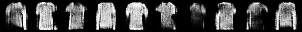

In [33]:
Image(f"generated_images_{mode}/epoch_19.png") # real images

**(8)** (2 points) Briefly comment on what you observe, will Kocho be able to sell any of these hoodies/T-shirts? Play with the network parameter sizes and the other hyperparameters, all while keeping in mind the difficulties of min-max optimization you've analyzed in the previous notebook.

<span style="color:red">

**Comments**

</span>

After training, we can see that the generator produces coherent shapes of hoodies and shirts. We can also notice a lack of diversity in the generated clothes. The loss is not always strictly decreasing due to the difficulty of min-max optimization but the overall quality suggests Kocho could still sell some of them.

Alternatively, to enforce Lipschitzness, the projection/clipping steps can be replaced with **LMO-based** (Linear Minimization Oracle) update derived from the Frank-Wolfe/Conditional Gradient method (SCG for the discriminator, uSCG for the generator). This approach maintains a momentum-averaged gradient and is known as the [Scion optimizer](https://arxiv.org/pdf/2502.07529).
$$
\begin{aligned}
g_d^{k} &= \alpha_d \text{SG}_d(d^k, h^k) + (1-\alpha_d)\, g_d^{k-1},\\
g_h^{k} &= \alpha_g \text{SG}_h(d^k, h^k) + (1-\alpha_g)\, g_h^{k-1}.
\end{aligned}
$$

**Discriminator (SCG; constrained):**
$$
d^{k+1} \;=\; (1-\gamma_d)\, d^{k} \;+\; \gamma_d \,\operatorname{lmo}_{\|\cdot\|_{D}}\!\left(+\,g_d^{k}\right).
$$

**Generator (uSCG; unconstrained):**
$$
h^{k+1} \;=\; h^{k} \;+\; \gamma_h \,\operatorname{lmo}_{\|\cdot\|_{H}}\!\left(-\,g_h^{k}\right).
$$

Here $\operatorname{lmo}_{\|\cdot\|}$ is the linear minimization oracle over the unit ball of the chosen norm.
You can choose $\|\cdot\|_D$ and $\|\cdot\|_H$ independently from:
- **Spectral**: $\operatorname{lmo}(S) = -\,U V^\top$ (singular vectors of $S$).
- **Frobenius**: $\operatorname{lmo}(S) = - S / \|S\|_F$ (Normalized SGD).
- **Max ($l_\infty$)**: $\operatorname{lmo}(S) = -\operatorname{sign}(S)$.


**(9)** (3 points) Implement the helper lmo funtions for spectral, frobenius and sign norms. 

For `lmo_spectral`, by using SVD (Singular Value Decomposition), you should find the singular vectors, $U$ and $V$. The LMO direction for the spectral norm is $-UV^T$. Ensure the function correctly handles 2D (Linear) and 4D (Conv) tensors by unfolding the Conv weights. When dim(grad) < 2, you can use sign lmo instead.

In [12]:
@torch.no_grad()
def lmo_spectral(grad):
    if grad.ndim == 2:  # Linear layer
        U, S, Vh = torch.linalg.svd(grad, full_matrices=False) 
        UVt = -U @ Vh  
        return UVt.view_as(grad)

    elif grad.ndim == 4:  # Conv or ConvTranspose
        out_c, in_c, kh, kw = grad.shape
        M = grad.reshape(out_c, kh * kw * in_c)  # FILL
        U, S, Vh = torch.linalg.svd(M, full_matrices=False)  # FILL
        UVt = -U @ Vh  # FILL
        return UVt.reshape(out_c, in_c, kh, kw)

    else:  # anything else — use sign lmo
        return lmo_sign(grad) # FILL

@torch.no_grad()
def lmo_frobenius(grad):
    norm = grad.norm(p='fro')
    epsilon = 1e-8
    return -grad / (norm + epsilon) # FILL

@torch.no_grad()
def lmo_sign(grad):
    return -grad.sign() # FILL

def choose_lmo(grad, norm_choice="sign"):
    if norm_choice == "spectral":
        return lmo_spectral(grad)
    if norm_choice == "frobenius":
        return lmo_frobenius(grad)
    if norm_choice == "sign":
        return lmo_sign(grad)

**(10)** (3 points) Now, implement the `step` method for the `SCION` optimizer class. 

In [13]:
from torch.optim.optimizer import Optimizer

class SCION(Optimizer):
    def __init__(self, params, lr=1e-3, momentum=1.0, norm: str='sign', scale=1.0, constrained=False):
        if norm not in {"spectral","frobenius","sign"}:
            raise ValueError("norm must be one of {'spectral','frobenius','sign'}")
        defaults = dict(lr=lr, momentum=momentum, scale=scale, constrained=constrained, norm=norm)
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self):
        for group in self.param_groups:
            lr = group['lr']
            momentum = group['momentum']
            constrained = group['constrained']
            norm = group['norm']
            scale = group['scale']

            for p in group['params']:
                g = p.grad
                if g is None:
                    continue
                state = self.state[p]

                if momentum != 1:
                    if 'momentum_buffer' not in state.keys():
                        state['momentum_buffer'] = torch.zeros_like(g)
                    buf = state['momentum_buffer']
                    buf.mul_(1-momentum).add_(g, alpha=momentum) #FILL
                    lmo_input = buf 
                else:
                    lmo_input = g
                
                direction = choose_lmo(+lmo_input, norm_choice=norm) #FILL
                update = scale * direction
                if constrained:
                    p.data.mul_(1 - lr) # FILL

                p.data.add_(lr*update) # FILL 

**(11)** (2 points) Implement an the alternating gradient ascent/descent update for the `SCION` optimizer. 

**Hints**: Thanks to lmo based updates of `SCION`, it is no longer necessary to enforce Lipschitzness.

In [14]:
def alternating_update_scion(step_k, d, g, d_optim, g_optim, noise_samples, real_samples, d_ratio=2):
        # FILL
    if step_k % d_ratio != 0:
        d_optim.zero_grad()
        d_loss = -objective(d, g, real_samples, noise_samples)
        d_loss.backward()
        d_optim.step()
        return d_loss.item()
    else:
        g_optim.zero_grad()
        g_loss = objective(d, g, real_samples, noise_samples)
        g_loss.backward()
        g_optim.step()
        return g_loss.item()

With all the ingredients in hand, we can train Kocho's WGAN with SCION now.

The following cell defines the two networks.

In [35]:
n_epochs = 20 # How many passes over the digit image dataset
noise_dim = 100 # Noise dimension for the generator
mode = "scion"

device = "cpu" # Change this if you can and want to use a GPU device 
d = DualVariable(mode=mode).to(device)
g = Generator(noise_dim=noise_dim).to(device)

d_constrained = True # FILL 
g_constrained = False # FILL 

We recommend the following hyperparameters to start with.

In [16]:
norm_d = "sign"
norm_g = "spectral"
lr = 2**-8 #change it to 2**-8
alpha = 0.9
scale = 5.0

Define `SCION` optimizers.

In [17]:
d_optim = SCION(d.parameters(), lr=lr, momentum=alpha, norm=norm_d, scale=scale, constrained=d_constrained)
g_optim = SCION(g.parameters(), lr=lr, momentum=alpha, norm=norm_g, scale=scale, constrained=g_constrained)

The following cell runs the training loop, this might take a few minutes.

In [18]:
train(d, g, d_optim, g_optim, alternating_update_scion, device=device,
      n_epochs=n_epochs, num_test_samples=100, noise_dim=noise_dim, f_ratio=2, mode=mode)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Batch:   0%|          | 0/188 [00:00<?, ?it/s]

Once the training is complete, you can visualize the training process in the following cell. Use the slider to scroll through generated image collages from every epoch.

In [19]:
def show_image(epoch):
    return Image(f"generated_images_{mode}/epoch_{epoch}.png")
interact(show_image, epoch=SelectionSlider(
    options=range(n_epochs),
    value=0,
    description="Epoch:",
    disabled=False,
    continuous_update=False,
    orientation="horizontal",
    readout=True
))

interactive(children=(SelectionSlider(continuous_update=False, description='Epoch:', options=(0, 1, 2, 3, 4, 5…

<function __main__.show_image(epoch)>

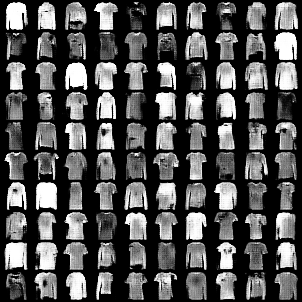

In [37]:
Image(f"generated_images_scion/epoch_19.png") # real images